In this notebook the various functions required to import the MUR data in the form of netCDF files are defined. These files are imported and converted to dataframes, then visualized being applied the Canny Algorithm

In [28]:
import os
import wget
import threading
import numpy as np
import pandas as pd
from math import floor
from pydap.client import open_url
from tqdm import tqdm
import sys
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import cv2
plt.rcParams["figure.figsize"] = 10, 8

### Code to download data from MUR

In [29]:
def boundingindex(dmin, dint, boundary0, boundary1):
    """
    get boundaries values to download the data already cropped
    """
    inx0 = max(int(floor((boundary0 - dmin) / dint)), 0)
    inx1 = max(int(floor((boundary1 - dmin) / dint)), 0)
    if inx0 > inx1:
        atemp = inx0
        inx0 = inx1
        inx1 = atemp
    return [inx0, inx1]

In [30]:
def get_mur_params(lon_box, lat_box):
    """
    Check sample file to get parameters for sst
    """
    mur_ncin = open_url(
        'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/002/20180102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
    lon = mur_ncin['lon']
    lat = mur_ncin['lat']
    lon_step = np.mean(np.diff(lon))
    lat_step = np.mean(np.diff(lat))
    [mur_i0, mur_i1] = boundingindex(lon[0][0].data, lon_step, lon_box[0], lon_box[1])
    [mur_j0, mur_j1] = boundingindex(lat[0][0].data, lat_step, lat_box[0], lat_box[1])

    return mur_i0, mur_i1, mur_j0, mur_j1

In [7]:
get_mur_params([-19, -5], [35, 45])

(16099, 17499, 12499, 13499)

In [31]:
def download_from_url(fileget, filenameout, replace, printiti):
    """
    function that tries to download data from "fileget" if the data didn't previously exist,
    the user asked to replace the old data, or the file has 0 bytes
    """
    exists = os.path.exists(filenameout)
    if exists:
        file_size = os.path.getsize(filenameout)
    else:
        file_size = 1
    if (not exists) or (replace and exists) or (file_size == 0):
        if exists:
            os.remove(filenameout)
        try:
            return wget.download(fileget, out=filenameout, bar=None)
        except Exception as e:
            if printiti:
                print(e)
                print("Error downloading")
                print("Download error url: " + fileget)
            return e
    return filenameout

In [32]:
def download_sst(path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    opendap_dir = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/' + str(
        date.year) + '/'
    filename = opendap_dir + "{0:0>3}".format(str(date.dayofyear)) + '/' + date.strftime(
        "%Y%m%d") + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4'
    filenameout = path + "sst_" + date.strftime("%Y%m%d") + '.nc'
    fileget = filename + '?analysed_sst[0:1:0][' + str(mur_j0) + ':1:' + str(mur_j1) + '][' + str(mur_i0) + ':1:' + str(
        mur_i1) + ']'
    download_from_url(fileget, filenameout, replace, 1)
    return

In [33]:
def download_sst_thread(data_range, sst_path, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    for date in tqdm(data_range, desc='SST', file=sys.stdout):
        download_sst(sst_path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace)
    return

In [38]:
#Importar diversos dias simultaneamente
download_sst_thread(data_range = pd.date_range(start=pd.to_datetime('20190901'), end=pd.to_datetime('20190930')), sst_path='../data/', mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

SST: 100%|██████████████████████████████████████| 30/30 [01:53<00:00,  3.79s/it]


In [28]:
# Do download individual days of MUR data
download_sst(path = "../data/", date = pd.to_datetime('20190725'), mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

#### Merge dos muitos netCDF files com a data do MUR:

In [39]:
ds = xr.open_mfdataset('../data/sst*.nc',combine = 'nested', concat_dim="time")

In [40]:
ds.to_netcdf('../data/murSept2019.nc')

### Importação dos dados do MUR

Para já apenas foi feito o download relativo ao dia 25 de Julho de 2019

Importar o ficheiro netCDF da pasta data do repositório e depois converte-lo para o formato de dataframe

In [2]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [3]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [4]:
nc_path = os.path.join(data_folder, "sst_20190725.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [5]:
print(ds) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7
    title: Daily MUR SST, Final product
    summary: A merged, multi-sensor L4 Foundation SST analysis product from JPL.
    references: http://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST
    institution: Jet Propulsion Laboratory
    history: created at nominal 4-day latency; replaced nrt (1-day latency) version.
2022-03-15 11:27:14 GMT Hyrax-1.16.0 https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2019/206/20190725090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4?analysed_sst[0:1:0][12499:1:13499][16099:1:17499]
    comment: MUR = \"Multi-scale Ultra-high Resolution\"
    license: These data are available free of charge under data policy of JPL PO.DAAC.
    id: MUR-JPL-L4-GLOB-v04.1
    naming_authority: org.ghrsst
    product_version: 04.1
    uuid: 27665bc0-d5fc-11e1-9b23-0800200c9a66
    gds_version_i

In [6]:
#Converter o ficheiro netCDF para uma dataframe
datadf = data.to_dataframe()
datadf = datadf.reset_index()

In [7]:
datadf['analysed_sst'] =  datadf['analysed_sst']-273.15    #convert to celsius
datadf

,lat,lon,time,analysed_sst
0,35.0,-19.000000,2019-07-25 09:00:00,22.924988
1,35.0,-18.990000,2019-07-25 09:00:00,22.945007
2,35.0,-18.980000,2019-07-25 09:00:00,22.971985
3,35.0,-18.969999,2019-07-25 09:00:00,23.001007
4,35.0,-18.959999,2019-07-25 09:00:00,23.029999
...,...,...,...,...
1402396,45.0,-5.040000,2019-07-25 09:00:00,21.966003
1402397,45.0,-5.030000,2019-07-25 09:00:00,21.977997
1402398,45.0,-5.020000,2019-07-25 09:00:00,21.980011
1402399,45.0,-5.010000,2019-07-25 09:00:00,21.975006


### Mapa de acordo com os dados obtidos no NetCDF do MUR (valores verdadeiros de temperaturas)

In [8]:
#Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
sst = datadf.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values

In [9]:
sst = np.flipud(sst)   #flipud -> Reverse the order of elements along axis 0 (up/down).

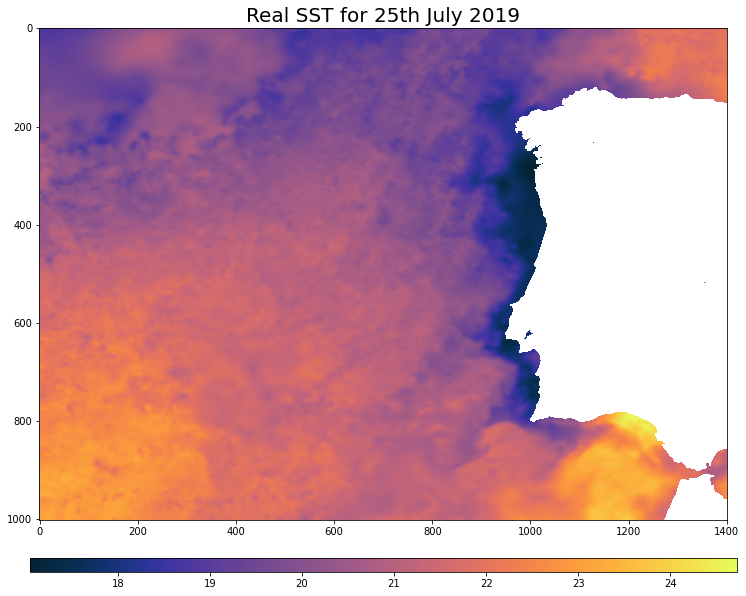

In [10]:
#Plotar o numpy array para ver se de facto corresponde há imagem em causa
plt.rcParams["figure.figsize"] = 14, 10
import cmocean
img = plt.imshow(sst, cmocean.cm.thermal)
plt.colorbar(img, orientation='horizontal', fraction=0.026, pad=0.07, aspect=50)
plt.title('Real SST for 25th July 2019', fontsize=20);


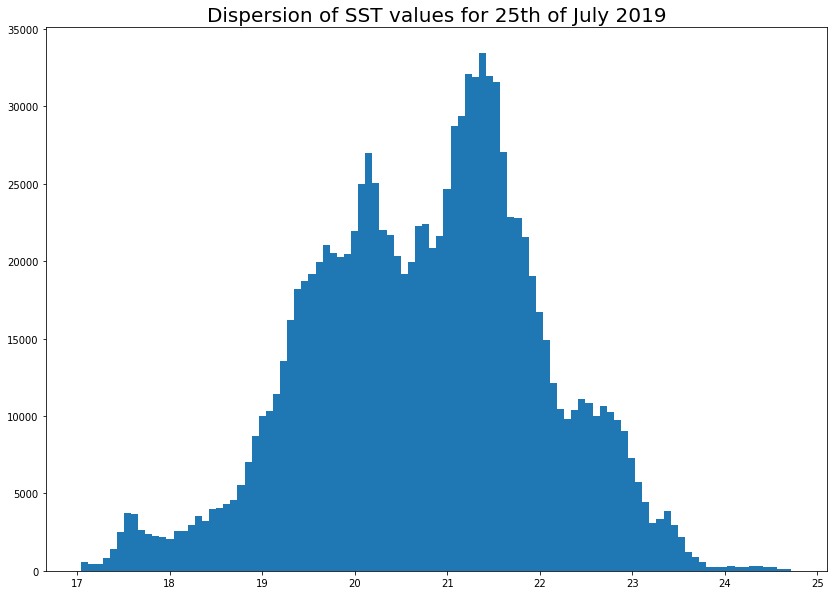

In [11]:
plt.hist(sst.flatten(), bins=100)
plt.title('Dispersion of SST values for 25th of July 2019', fontsize=20);

# Aplicar o Canny 

#### Aplicar Canny aos dados do MUR com valores de temperatura na gama 0-255, sem mask

Para se poder aplicar o canny algorithm ao array, os valores estarão na gama 0-255 e têm de estar no formato uint8

In [12]:
#Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
sst2 = datadf.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values
    
#Converter os valores de temperatura no formato uint8 com valores entre 0-255
sst3 = ((sst2 - np.nanmin(sst2)) * (1/(np.nanmax(sst2) - np.nanmin(sst2)) * 255)).astype('uint8')

sst3 = np.flipud(sst3)   #flipud -> Reverse the order of elements along axis 0 (up/down).

In [13]:
sst3

array([[ 61,  61,  61, ..., 163, 163, 163],
       [ 61,  61,  61, ..., 162, 162, 162],
       [ 62,  61,  61, ..., 162, 162, 161],
       ...,
       [194, 195, 196, ...,   0,   0,   0],
       [194, 195, 196, ...,   0,   0,   0],
       [195, 196, 196, ...,   0,   0,   0]], dtype=uint8)

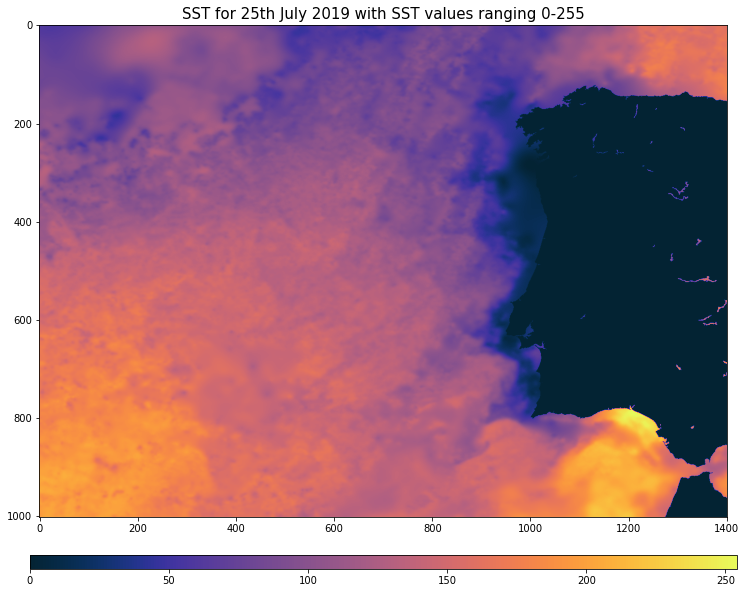

In [14]:
img2 = plt.imshow(sst3, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = 14, 10
plt.colorbar(img2, orientation='horizontal', fraction=0.026, pad=0.07, aspect=50)
plt.title('SST for 25th July 2019 with SST values ranging 0-255', fontsize=15);

#### Problema:
Quando converto os valores do array para o formato uint8 surgem estas "descontinuidades" dentro da zona continental que depois se vão traduzir em frentes após a aplicação do Canny. Estas descontinuidades devem-se (creio) à existência de rios e lagos que são detectados.

In [15]:
canny = cv2.Canny(sst3, 90, 180, L2gradient=True, apertureSize=3)

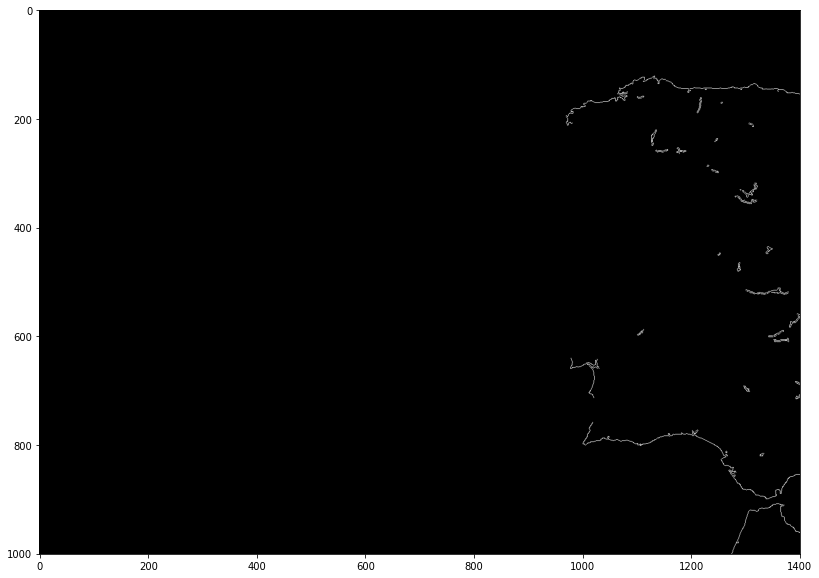

In [16]:
plt.imshow(canny, 'gray')

In [ ]:
# Só se obtem resultados se o parametro apertureSize >3 (5 ou 7) -> kernel size do sobel operator

#### Aplicar Canny aos dados do MUR com valores de temperatura na gama 0-255, com mask

In [17]:

#Pegar na df dum dia e converte-la num np array com os valores de Temperatura para os valores de long e lati
sst4 = datadf.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values
    
#Converter os valores de temperatura no formato uint8 com valores entre 0-255
sst5 = ((sst4 - np.nanmin(sst4)) * (1/(np.nanmax(sst4) - np.nanmin(sst4)) * 255)).astype('uint8')

sst5 = np.flipud(sst5)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
#apply the canny algorithm and plot the image with the edges
canny_mask = cv2.Canny(sst5, 220, 250, L2gradient=False, apertureSize=5)
    
mask = np.isnan(np.flipud(sst4))    #Boolean array é True onde o array original (Temp) tinha valores Nan
mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array cujos pixels= 255 quando mask=True
#Fazer uma dilatação para assegurar que os pixeis que pertencem à costa não são considerados como frentes no canny
kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask255, kernel)
canny_mask =np.ma.masked_where(mask_dilated==255, canny_mask)

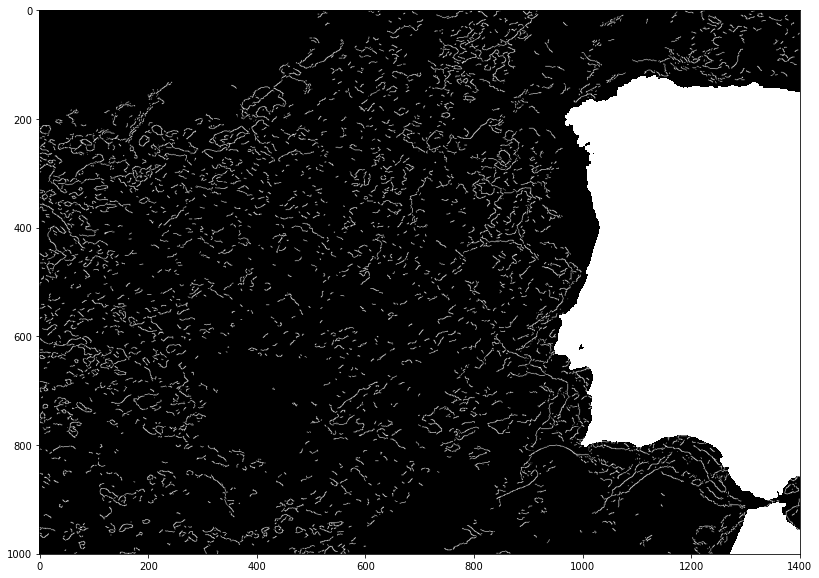

In [18]:
plt.imshow(canny_mask, 'gray')

#### Aplicar Canny aos dados do MUR com valores de temperatura na gama 0-255, com mask e com gaussian filter

Quando se aplica um gaussian filter a um masked array, a mask desaparece

In [19]:
from scipy.ndimage import gaussian_filter

In [20]:
sst_gaussfilter = sst5.copy()
sst_gaussfilter

array([[ 61,  61,  61, ..., 163, 163, 163],
       [ 61,  61,  61, ..., 162, 162, 162],
       [ 62,  61,  61, ..., 162, 162, 161],
       ...,
       [194, 195, 196, ...,   0,   0,   0],
       [194, 195, 196, ...,   0,   0,   0],
       [195, 196, 196, ...,   0,   0,   0]], dtype=uint8)

In [21]:
sst_gaussfilter = gaussian_filter(sst_gaussfilter, sigma=5)
sst_gaussfilter

array([[ 60,  60,  60, ..., 161, 161, 161],
       [ 60,  60,  60, ..., 161, 161, 161],
       [ 60,  60,  60, ..., 161, 161, 161],
       ...,
       [196, 196, 196, ...,   0,   0,   0],
       [196, 196, 197, ...,   0,   0,   0],
       [196, 196, 197, ...,   0,   0,   0]], dtype=uint8)

In [22]:
sst_gaussfilter.max()

246

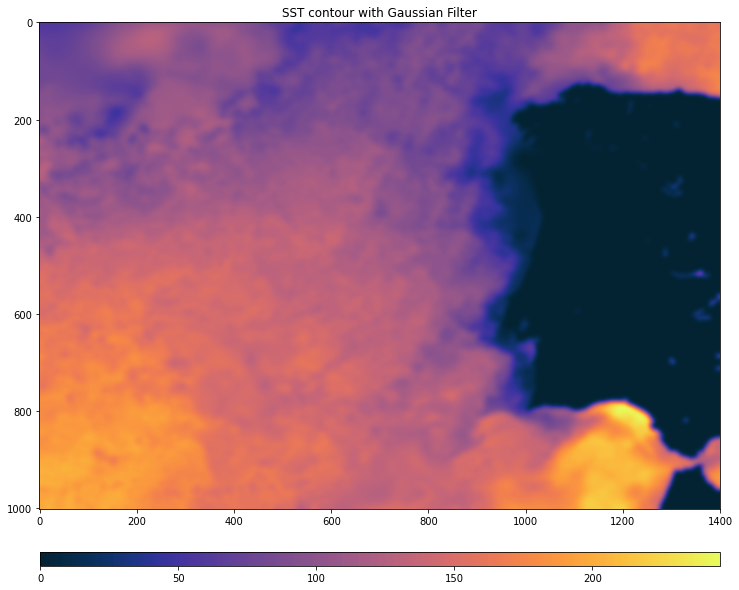

In [23]:
img3 = plt.imshow(sst_gaussfilter, cmocean.cm.thermal)
plt.colorbar(img3, orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
plt.title('SST contour with Gaussian Filter')
plt.show()

In [24]:
canny_gaussfilter = cv2.Canny(sst_gaussfilter, 90, 180, L2gradient=True, apertureSize=5)

In [25]:
#Apply mask to continental zone

mask = np.isnan(np.flipud(sst4))    #Boolean array é True onde o array original (Temp) tinha valores Nan
mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array cujos pixels= 255 quando mask=True
#Fazer uma dilatação para assegurar que os pixeis que pertencem à costa não são considerados como frentes no canny
kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask255, kernel)
canny_gaussfilter =np.ma.masked_where(mask_dilated==255, canny_gaussfilter)

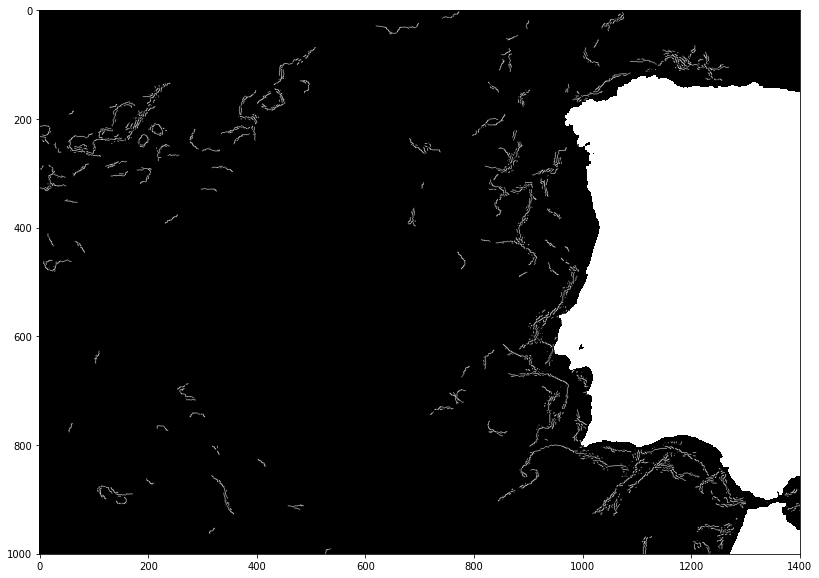

In [26]:
plt.imshow(canny_gaussfilter, 'gray')